### Initial set-up

Mount google drive

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify location of Data
#path = '/content/drive/MyDrive/Colab Notebooks/Term2/Hackathon/Data'
path = '/content/drive/MyDrive/Hackathon/Data'

Downloading YOLOv5 files

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10896, done.
remote: Total 10896 (delta 0), reused 0 (delta 0), pack-reused 10896
Receiving objects: 100% (10896/10896), 11.00 MiB | 3.79 MiB/s, done.
Resolving deltas: 100% (7529/7529), done.


In [ ]:
!pip install -r yolov5/requirements.txt

### Eploration, annotation conversion, data partitioning

In [ ]:
import json
import glob
import torch
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
image_path = os.path.join(path,"Detection_Train_Set","Detection_Train_Set_Img")
json_path = os.path.join(path,"Detection_Train_Set","Detection_Train_Set_Json")
image_path_list = glob.glob(image_path+"/*")
image_name_list = [os.path.basename(x) for x in image_path_list]

Exploring different classes in images & annotations

In [ ]:
# Check how many classes are in the training data (ClassID, ClassName, GeometryType)
class_list = []
for i in image_name_list:
  try:
    # Opening JSON file
    f = open(json_path+'/'+i+'.json')
    # returns JSON object as a dictionary
    json_data = json.load(f)
    # Closing file
    f.close()

    for obj in json_data['objects']:
      class_list.append((obj['classId'], obj['classTitle'], obj['geometryType']))
  except FileNotFoundError:
    print("Json file not found for " + i)
  except:
    print('Something else went wrong')

# All classes found in training data (ClassID, ClassName, GeometryType)
set(class_list)

Json file not found for Batch2__Roissy_02frame928.jpg
Json file not found for Batch2__Roissy_02frame926.jpg


{(1285799, 'Vertical_formwork', 'polygon'),
 (1285804, 'Concrete_pump_hose', 'polygon'),
 (1285809, 'Mixer_truck', 'rectangle'),
 (1285811, 'People', 'rectangle')}

Converting annotations to YOLO format

In [ ]:
# Convert json files to info-dictionary format first
def convert_to_info_dict(file_name):
  file_path = os.path.join(json_path,file_name+'.json')
  # Opening JSON file
  f = open(file_path)
  # Returning JSON object as a dictionary
  data = json.load(f)
  # Closing file
  f.close()
  anno = dict()
  anno['filename'] = file_name
  anno['image_size'] = (data['size']['width'],data['size']['height'],3)
  anno['bboxes'] = []
  for i in data['objects']:
    #if i['classTitle'] == 'People':
    #if we change the code to the comment above, we will detect only people and omit mixer trucks.
    if i['geometryType'] == 'rectangle':
      xmin = min(i['points']['exterior'][0][0], i['points']['exterior'][1][0])
      ymin = min(i['points']['exterior'][0][1], i['points']['exterior'][1][1])
      xmax = max(i['points']['exterior'][0][0], i['points']['exterior'][1][0])
      ymax = max(i['points']['exterior'][0][1], i['points']['exterior'][1][1])
      anno['bboxes'].append({'class': i['classTitle'], 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})
  return anno

In [ ]:
# Make some directories that will be used later
!mkdir /content/hackathon_data
!mkdir /content/hackathon_data/images
!mkdir /content/hackathon_data/labels

In [ ]:
# Dictionary that maps class names to IDs
# Only Class 0 and 1 will be used here
class_name_to_id_mapping = {"Vertical_formwork": 3,
                           "Concrete_pump_hose": 2,
                           "Mixer_truck": 1,
                           "People": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        # Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("/content/hackathon_data/labels", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Convert all annotations to YOLO format

files_not_found = []

for i in image_name_list:

  try:
    anno = convert_to_info_dict(i)
    convert_to_yolov5(anno)

  except FileNotFoundError:
    files_not_found.append(i)
    print("Json file not found for " + i)

  except:
    print('Something else went wrong')


In [ ]:
# zip and download the YOLO annotations
!zip -r /content/file.zip /content/hackathon_data/labels

from google.colab import files
files.download("/content/file.zip")

  adding: content/hackathon_data/labels/ (stored 0%)
  adding: content/hackathon_data/labels/Batch2__Devisubox2_06frame1212.txt (deflated 67%)
  adding: content/hackathon_data/labels/Batch2__Nouveau_campus_03frame1581.txt (deflated 67%)
  adding: content/hackathon_data/labels/Batch2__Marseille_01frame1136.txt (deflated 49%)
  adding: content/hackathon_data/labels/Batch2__Marseille_01frame881.txt (deflated 45%)
  adding: content/hackathon_data/labels/Batch2__Roissy_02frame1764.txt (deflated 51%)
  adding: content/hackathon_data/labels/Batch2__Roissy_02frame1689.txt (deflated 40%)
  adding: content/hackathon_data/labels/Batch2__Marseille_01frame835.txt (deflated 52%)
  adding: content/hackathon_data/labels/Batch2__Marseille_01frame755.txt (deflated 29%)
  adding: content/hackathon_data/labels/Batch2__Devisubox2_06frame7117.txt (deflated 68%)
  adding: content/hackathon_data/labels/Batch2__BioSAV_BIofiltration_18mois_05frame3364.txt (deflated 61%)
  adding: content/hackathon_data/labels/B

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Testing the annotations**

We randomly load one of the annotations and plot boxes using the transformed annotations, and visually inspect it to see whether our code has worked as intended.

Run the next cell multiple times. Every time, a random annotation is sampled.

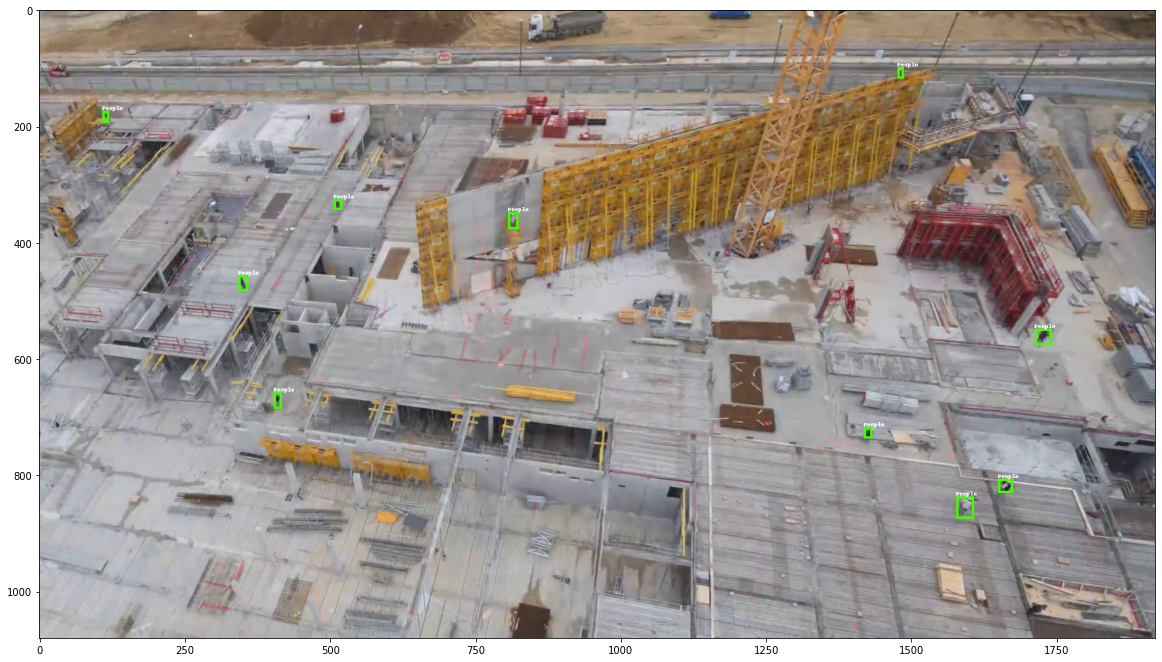

In [ ]:
# Testing the annotations


annotations = glob.glob('/content/hackathon_data/labels/*')

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline=(64, 255, 0), width=4)
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    plt.figure(figsize=(20,20))
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

# Get the corresponding image file
image_file = os.path.join(image_path,os.path.basename(annotation_file).replace("txt", "jpg"))
assert os.path.exists(image_file)

# Load the image
image = Image.open(image_file)

# Plot the Bounding Box
plot_bounding_box(image, annotation_list)

**Partition the Dataset**

Next we partition the dataset into train, validation, and test sets containing 85%, 12%, and 3% of the data, respectively. 

In [ ]:
# Read images and annotations
images = [os.path.join(image_path, x) for x in os.listdir(image_path)]
annotations = [os.path.join('/content/hackathon_data/labels', x) for x in os.listdir('/content/hackathon_data/labels') if x[-3:] == "txt"]

# Remove images that don not have corresponding annotations
for f in files_not_found:
  images.remove(os.path.join(image_path, f))

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.15, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.2, random_state = 1)


In [ ]:
# Create the folders to keep the splits
!mkdir /content/hackathon_data/images/train /content/hackathon_data/images/val /content/hackathon_data/images/test /content/hackathon_data/labels/train /content/hackathon_data/labels/val /content/hackathon_data/labels/test

In [ ]:
# Utility function to move/copy images and annotations
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

def copy_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy2(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
copy_files_to_folder(train_images, '/content/hackathon_data/images/train/')
copy_files_to_folder(val_images, '/content/hackathon_data/images/val/')
copy_files_to_folder(test_images, '/content/hackathon_data/images/test/')
move_files_to_folder(train_annotations, '/content/hackathon_data/labels/train/')
move_files_to_folder(val_annotations, '/content/hackathon_data/labels/val/')
move_files_to_folder(test_annotations, '/content/hackathon_data/labels/test/')

### Train the model

In [ ]:
# Move to yolov5 as the working directory
%cd /content/yolov5

/content/yolov5


In [ ]:
# Install Weights & Biases (wandb) for real-time visualization and cloud logging of training runs
!pip install wandb

     |████████████████████████████████| 1.7 MB 12.7 MB/s 
     |████████████████████████████████| 180 kB 50.6 MB/s 
     |████████████████████████████████| 144 kB 47.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a96a504de0c6c807399d5df370af483808106cc605d8be2c0c6743c41de88e09
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


Create yaml file to provide file paths

In [ ]:
with open('hackathon_data.yaml', 'w+') as file:
    file.write(
        """
        train: ../hackathon_data/images/train/
        val:  ../hackathon_data/images/val/
        test: ../hackathon_data/images/test/

        # number of classes
        nc: 2

        # class names
        names: ["People", "Mixer_truck"]
        """
    )

**Tune the hyperparameters**

Hyperparameter evolution is a method of Hyperparameter Optimization using a Genetic Algorithm (GA) for optimization. 


Traditional methods like grid searches can quickly become intractable due to 1) the high dimensional search space 2) unknown correlations among the dimensions, and 3) expensive nature of evaluating the fitness at each point, making GA a suitable candidate for hyperparameter searches.

In [ ]:
# Tune the hyperparameters with 50 generations
# Visualization of the process is saved in https://wandb.ai/zxying/evolve?workspace=user-zxying
!python train.py --epochs 10 --data hackathon_data.yaml --weights yolov5m.pt --cache --evolve 50

In [ ]:
3# Import hackathon_data.yaml to yolov5/data first and train the model
# Visualization of the result is saved in https://wandb.ai/zxying/YOLOv5/runs/eiguqnee?workspace=user-zxying
!python train.py --img 640 --cfg yolov5m.yaml --hyp /content/yolov5/runs/evolve/exp/hyp_evolve.yaml --batch 16 --epochs 50 --data hackathon_data.yaml --weights yolov5m.pt --workers 24 --name yolo_hackathon_det

In [ ]:
# Train the model with a larger model YOLOv5l
!python train.py --img 640 --cfg yolov5l.yaml --hyp /content/yolov5/runs/evolve/exp/hyp_evolve.yaml --batch 16 --epochs 50 --data hackathon_data.yaml --weights yolov5l.pt --workers 24 --name yolo_hackathon_det

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 3
wandb: You chose 'Don't visualize my results'
train: weights=yolov5l.pt, cfg=yolov5l.yaml, data=hackathon_data.yaml, hyp=/content/yolov5/runs/evolve/exp/hyp_evolve.yaml, epochs=1, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=yolo_hackathon_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-266-g07221f1 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, mo

In [ ]:
# Train the model with a smaller model YOLOv5s
!python train.py --img 640 --cfg yolov5s.yaml --hyp /content/yolov5/runs/evolve/exp/hyp_evolve.yaml --batch 16 --epochs 50 --data hackathon_data.yaml --weights yolov5s.pt --workers 24 --name yolo_hackathon_det

In [ ]:
# Train the model with a smaller model YOLOv5s and with default hyperparameters
!python train.py --img 640 --cfg yolov5m.yaml --hyp hyp.scratch.yaml --batch 16 --epochs 50 --data hackathon_data.yaml --weights yolov5m.pt --workers 24 --name yolo_hackathon_det

In [ ]:
# Save the result of the best performing model (YOLOv5l)
!zip -r /content/file.zip /content/yolov5/runs/train/yolo_hackathon_det

  adding: content/yolov5/runs/train/yolo_hackathon_det3/ (stored 0%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/results.csv (deflated 69%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/hyp.yaml (deflated 45%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/train_batch0.jpg (deflated 2%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/val_batch0_labels.jpg (deflated 4%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/P_curve.png (deflated 27%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/train_batch1.jpg (deflated 2%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/val_batch0_pred.jpg (deflated 4%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/opt.yaml (deflated 46%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/val_batch1_labels.jpg (deflated 3%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/confusion_matrix.png (deflated 37%)
  adding: content/yolov5/runs/train/yolo_hackathon_det3/F1_curve.

### Test the model

In [ ]:
# Copy the real test dataset to another folder 
!mkdir /content/hackathon_data/test_images/

test_img_path = os.path.join(path,"Detection_Test_Set","Detection_Test_Set_Img")
test_imgs = [os.path.join(test_img_path,x) for x in os.listdir(test_img_path) if x.endswith(".jpg")]

copy_files_to_folder(test_imgs, '/content/hackathon_data/test_images')

Depending on how many models we tried training before, there might be multiple folders named "yolo_hackathon_det", "yolo_hackathon_det2" and so on. For parameter "--weights" and "--name" use the folder path you want to use the weights from and to save the results to.

In [ ]:
# Detect objects (people, mixer trucks) in test images using our trained model
!python detect.py --source /content/hackathon_data/test_images/ --weights runs/train/yolo_hackathon_det3/weights/best.pt --conf 0.1 --name yolo_hackathon_det3 --save-txt --save-conf

detect: weights=['runs/train/yolo_hackathon_det3/weights/best.pt'], source=/content/hackathon_data/test_images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolo_hackathon_det3, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-266-g07221f1 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 367 layers, 46113663 parameters, 0 gradients, 107.8 GFLOPs
image 1/100 /content/hackathon_data/test_images/2019-10-17-13-30-11.jpg: 512x640 Done. (0.134s)
image 2/100 /content/hackathon_data/test_images/2019-10-17-13-42-19.jpg: 512x640 Done. (0.123s)
image 3/100 /content/hackathon_data/test_images/2019-10-17-13-54-13.jpg: 512x640 Done. (0.122s)
image 4/100 /content/hackathon_data/t

Again, use the correct intended path to zip the file for downloading

In [ ]:
# Save the annotated images and label results
!zip -r /content/file_image.zip /content/yolov5/runs/detect/yolo_hackathon_det3

  adding: content/yolov5/runs/detect/yolo_hackathon_det3/ (stored 0%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/2019-10-17-13-42-19.jpg (deflated 2%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/frame1631.jpg (deflated 1%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/frame525.jpg (deflated 0%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/frame1602.jpg (deflated 1%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/2020-07-15-11-49-12.jpg (deflated 3%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/frame1592.jpg (deflated 1%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/2020-08-13-18-39-10.jpg (deflated 2%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/2020-08-13-19-44-13.jpg (deflated 2%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/frame944.jpg (deflated 1%)
  adding: content/yolov5/runs/detect/yolo_hackathon_det3/frame517.jpg (deflated 0%)
  adding: content/yolov5/runs/detect/yolo_h

### Make test image clusters

In [ ]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [ ]:
test_path = os.path.join(path,"Detection_Test_Set","Detection_Test_Set_Img")

# this list holds all the image filename
worksites = [os.path.join(test_path,x) for x in os.listdir(test_path) if x.endswith(".jpg")]          
            
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features
   
data = {}


# lop through each image in the dataset
for worksite in worksites:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(worksite,model)
        data[worksite] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(os.path.join(test_path,"/extracted_features"),'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=0)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
# cluster feature vectors

kmeans = KMeans(n_clusters = 7, random_state = 0)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets us view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        
   
# Below is just incase we want to see which value for k might be the best. 
# Since we know there are 7 clusters, we can comment this part

# sse = []
# list_k = list(range(3, 50))

# for k in list_k:
#     # km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
#     km = KMeans(n_clusters=k, random_state=0)
#     km.fit(x)
    
#     sse.append(km.inertia_)

# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse)
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance');

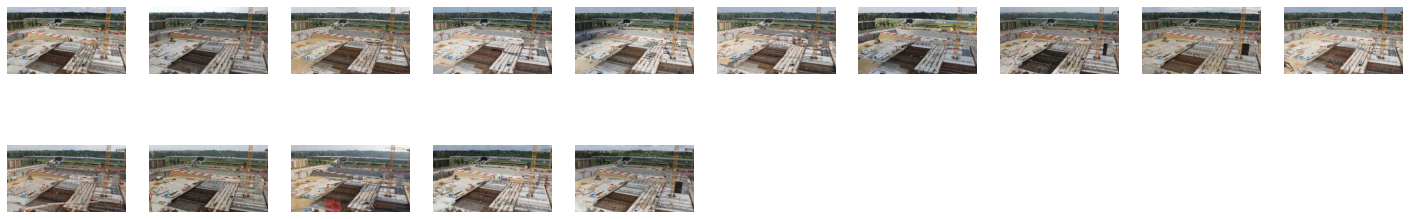

In [ ]:
# Check any cluster
view_cluster(2)

In [ ]:
clusters = {}
for item in groups:
  clusters[int(item)] = groups[item]

#Saving clusters information
with open(path+'clusters.json', 'w') as fp:
    json.dump(clusters, fp)

### Generate heat maps

In [ ]:
import cv2
import numpy as np
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow

!mkdir -p /content/heatmaps/color /content/heatmaps/grayscale

def draw_heat_map(input_img, bboxes=[], color=True, count=0):
  # read image and convert to gray
  if color:
    img = cv2.imread(input_img, cv2.IMREAD_COLOR)
    save_folder = "color"
  else:
    img = cv2.imread(input_img, cv2.IMREAD_GRAYSCALE) 
    save_folder = "grayscale"
  # img = cv2.imread(input_img, cv2.COLOR_RGB2GRAY) 
  height = img.shape[0]
  width = img.shape[1]

  for cord in bboxes:
    if int(cord[0]) != 0: continue

    ymin = int((cord[1] - cord[3]/2) * width)
    ymax = int((cord[1] + cord[3]/2) * width)
    xmin = int((cord[2] - cord[4]/2) * height)
    xmax = int((cord[2] + cord[4]/2) * height)

    # print(xmin,",",xmax,",",ymin,",",ymax)

    # crop image
    crop = img[xmin:xmax, ymin:ymax]

    # get colormap from matplotlib and normalize
    colormap = cm.get_cmap('inferno', 256)
    cmsm = cm.ScalarMappable(cmap='inferno')

    # create 1D float gradient from 0 to 1 with 256 increments 
    # convert to rgba in range 0 to 255 (via bytes=True)
    # remove alpha channel and reshape to 256x1 3 channel from (256, 4)
    # convert rgb to bgr
    cmap = np.linspace(0, 1, 256, endpoint=True)
    cmap = cmsm.to_rgba(cmap, bytes=True)
    cmap = cmap[:, 0:-1].reshape((256, 1, 3))
    cmap = cv2.cvtColor(cmap, cv2.COLOR_RGB2BGR)

    # apply color map to crop
    crop_mapped = cv2.applyColorMap(crop, cmap)

    if not color:
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      color = True

    img[xmin:xmax, ymin:ymax] = crop_mapped

  # save result
  cv2.imwrite('/content/heatmaps/'+save_folder+'/heatmap_'+str(count)+'.jpg', img)

  # show result
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

In [ ]:
# Loading earlier saved clusters information
with open(path+'clusters.json', 'r') as fp:
    clusters = json.load(fp)

Correctly choose the path to pick the labels from.

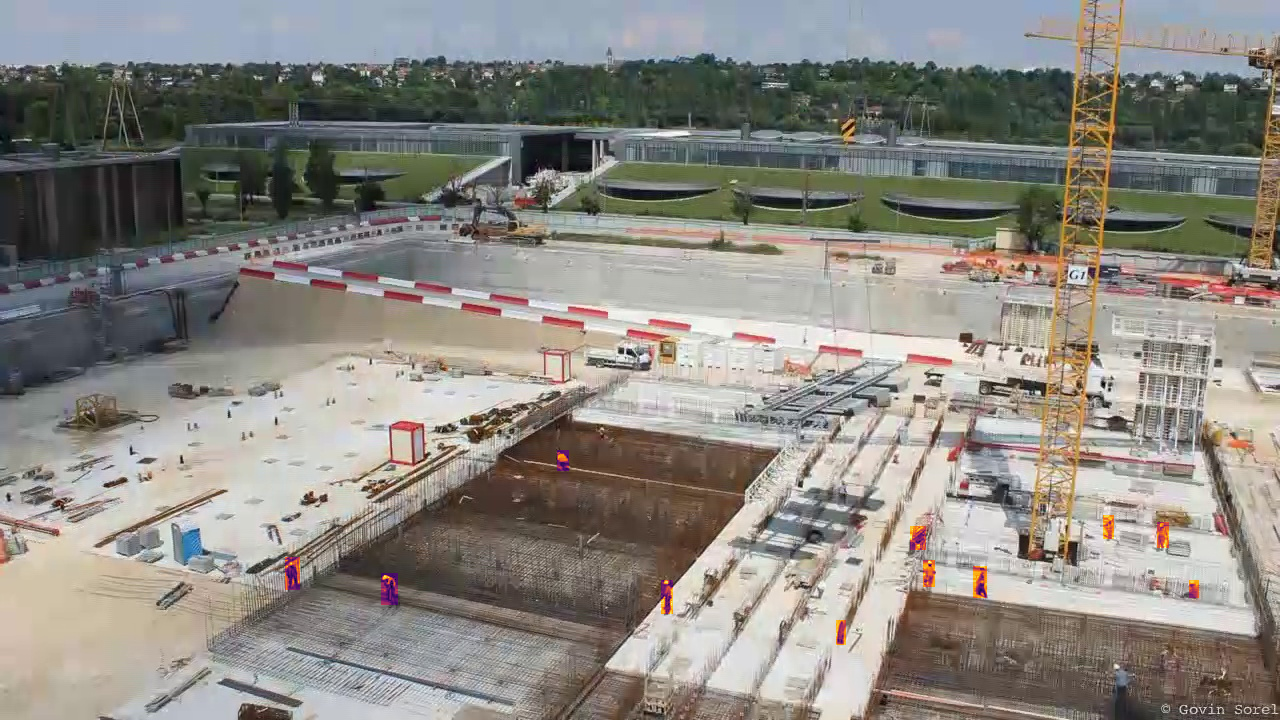